In [1]:
import folium
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

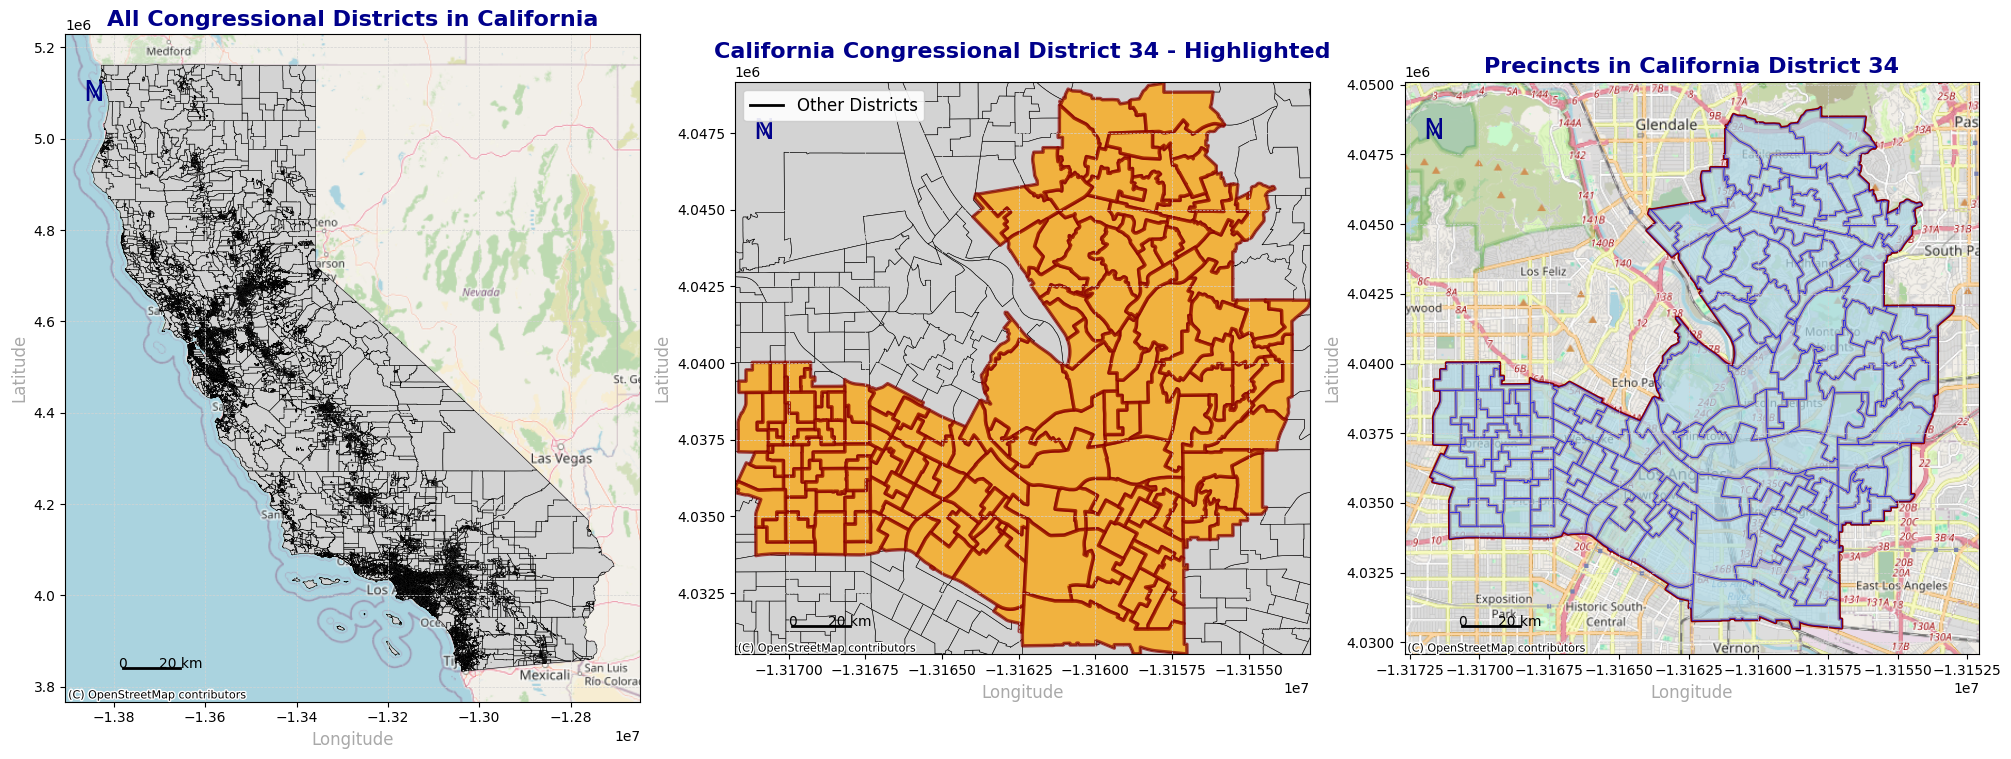

In [2]:
election_data = gpd.read_file("./ca_vest_20/ca_vest_20.shp")

# Filter for CA-34 district
ca_34_data = election_data[election_data["CDDIST"] == 34]


fig, axes = plt.subplots(1, 3, figsize=(20, 8), constrained_layout=True)

# Plot 1: All districts in California with a basemap
election_data.plot(ax=axes[0], color="lightgrey", edgecolor="black", linewidth=0.4)
ctx.add_basemap(axes[0], crs=election_data.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
axes[0].set_title("All Congressional Districts in California", fontsize=16, fontweight="bold", color="darkblue")

# Plot 2: Highlighted CA-34 with basemap
election_data.plot(ax=axes[1], color="lightgrey", edgecolor="black", linewidth=0.4)
ca_34_data.plot(ax=axes[1], color="orange", edgecolor="darkred", linewidth=2.5, alpha=0.7)
ctx.add_basemap(axes[1], crs=election_data.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
axes[1].set_title("California Congressional District 34 - Highlighted", fontsize=16, fontweight="bold", color="darkblue")

# Zoom into CA-34
minx, miny, maxx, maxy = ca_34_data.total_bounds
buffer = 0.1
axes[1].set_xlim(minx - buffer, maxx + buffer)
axes[1].set_ylim(miny - buffer, maxy + buffer)

# Plot 3: Precincts within CA-34
ca_34_data.plot(ax=axes[2], color="none", edgecolor="darkred", linewidth=2.5)
precincts_ca_34 = election_data[election_data["CDDIST"] == 34]
precincts_ca_34.plot(ax=axes[2], color="lightblue", edgecolor="blue", linewidth=0.5, alpha=0.7)
ctx.add_basemap(axes[2], crs=election_data.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
axes[2].set_title("Precincts in California District 34", fontsize=16, fontweight="bold", color="darkblue")

for ax in axes:
    ax.annotate('N', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=20, ha='center', color='darkblue',
                arrowprops=dict(facecolor='darkblue', edgecolor='darkblue', arrowstyle="->"))

for ax in axes:
    ax.annotate("0", xy=(0.1, 0.05), xycoords="axes fraction", fontsize=10, ha="center", color="black")
    ax.annotate("20 km", xy=(0.2, 0.05), xycoords="axes fraction", fontsize=10, ha="center", color="black")
    ax.plot([0.1, 0.2], [0.05, 0.05], transform=ax.transAxes, color="black", lw=2)

axes[1].legend(["Other Districts", "CA-34"], loc="upper left", frameon=True, framealpha=0.9, fontsize=12)

for ax in axes:
    ax.grid(color="lightgrey", linestyle="--", linewidth=0.5)
    ax.set_xlabel("Longitude", fontsize=12, color="darkgrey")
    ax.set_ylabel("Latitude", fontsize=12, color="darkgrey")

plt.savefig("CA_Districts_Enhanced.png", dpi=300)
plt.show()


In [3]:
election_data = gpd.read_file("./ca_vest_20/ca_vest_20.shp")
race_data = gpd.read_file("./ca_race_2022_bg/ca_race_2022_bg.shp")

if election_data.crs != race_data.crs:
    race_data = race_data.to_crs(election_data.crs)

integrated_data = gpd.sjoin(election_data, race_data, how="left", predicate="intersects")
ca_34_data = integrated_data[integrated_data["CDDIST"] == 34]

/home/test/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/test/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/test/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

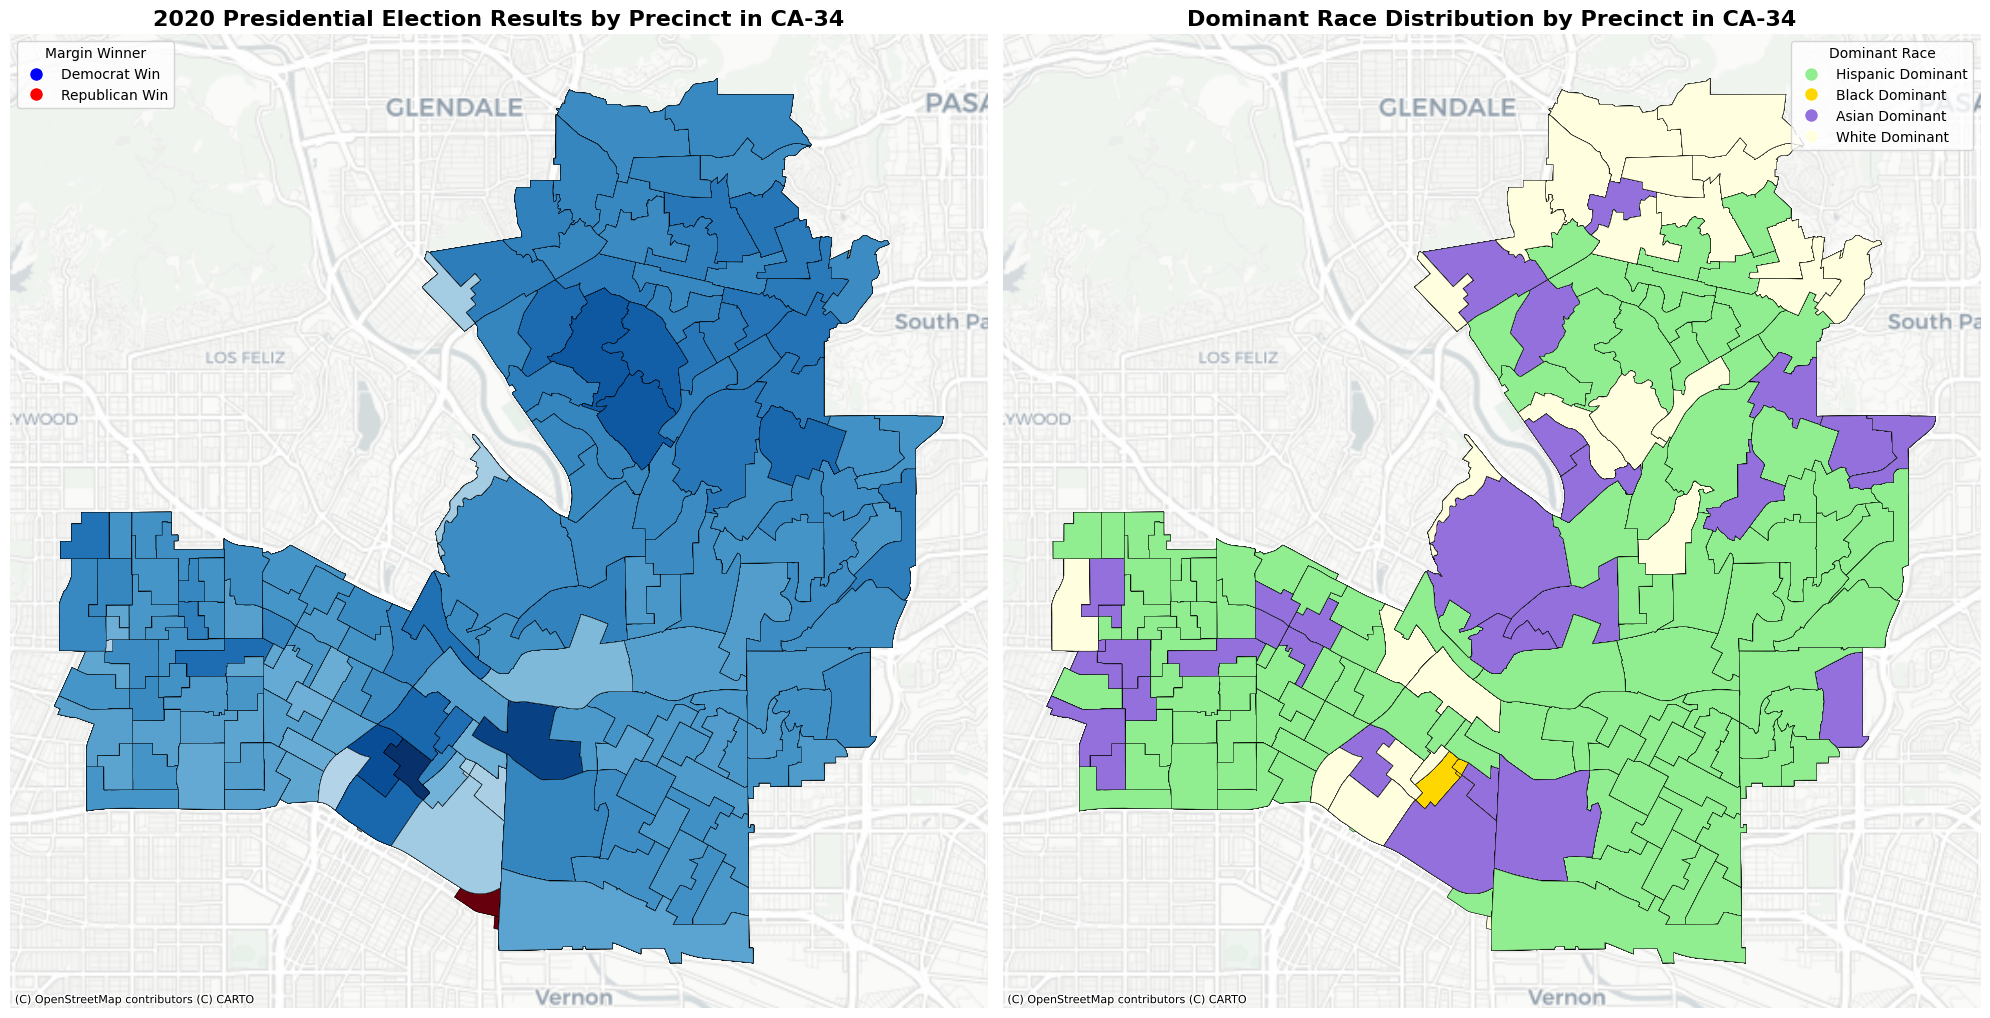

In [4]:
ca_34_data["Margin"] = ca_34_data["G20PREDBID"] - ca_34_data["G20PRERTRU"]
race_columns = ["WHT_NHSP22", "BLK_NHSP22", "ASN_NHSP22", "HSP_POP22"]
ca_34_data["Dominant_Race"] = ca_34_data[race_columns].idxmax(axis=1)

def get_color(row):
    if row["Margin"] > 0:  # Biden won
        return plt.cm.Blues(np.interp(row["Margin"], [0, ca_34_data["Margin"].max()], [0.3, 1]))
    elif row["Margin"] < 0:  # Trump won
        return plt.cm.Reds(np.interp(abs(row["Margin"]), [0, abs(ca_34_data["Margin"].min())], [0.3, 1]))
    else:
        return "grey"

ca_34_data["Color"] = ca_34_data.apply(get_color, axis=1)

race_color_map = {
    "HSP_POP22": "lightgreen",    # Hispanic
    "BLK_NHSP22": "gold",         # Black
    "ASN_NHSP22": "mediumpurple", # Asian
    "WHT_NHSP22": "lightyellow"   # White
}
ca_34_data["Race_Color"] = ca_34_data["Dominant_Race"].map(race_color_map)


fig, axes = plt.subplots(1, 2, figsize=(20, 12))

# Plot 1: Election Results (Winner and Margin)
ca_34_data.plot(color=ca_34_data["Color"], ax=axes[0], edgecolor="black", linewidth=0.3)
axes[0].set_title("2020 Presidential Election Results by Precinct in CA-34", fontsize=16, fontweight="bold")
axes[0].axis("off")
ctx.add_basemap(axes[0], crs=ca_34_data.crs.to_string(), source=ctx.providers.CartoDB.Positron)

election_legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Democrat Win', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Republican Win', markerfacecolor='red', markersize=10),
]
axes[0].legend(handles=election_legend_elements, loc="upper left", title="Margin Winner")

# Plot 2: Race Dominance Distribution
ca_34_data.plot(color=ca_34_data["Race_Color"], ax=axes[1], edgecolor="black", linewidth=0.3)
axes[1].set_title("Dominant Race Distribution by Precinct in CA-34", fontsize=16, fontweight="bold")
axes[1].axis("off")
ctx.add_basemap(axes[1], crs=ca_34_data.crs.to_string(), source=ctx.providers.CartoDB.Positron)

race_legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Hispanic Dominant', markerfacecolor='lightgreen', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Black Dominant', markerfacecolor='gold', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Asian Dominant', markerfacecolor='mediumpurple', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='White Dominant', markerfacecolor='lightyellow', markersize=10)
]
axes[1].legend(handles=race_legend_elements, loc="upper right", title="Dominant Race")

plt.tight_layout()
plt.savefig("CA34_Election_Race_Distribution.png", dpi=300)
plt.show()


/home/test/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


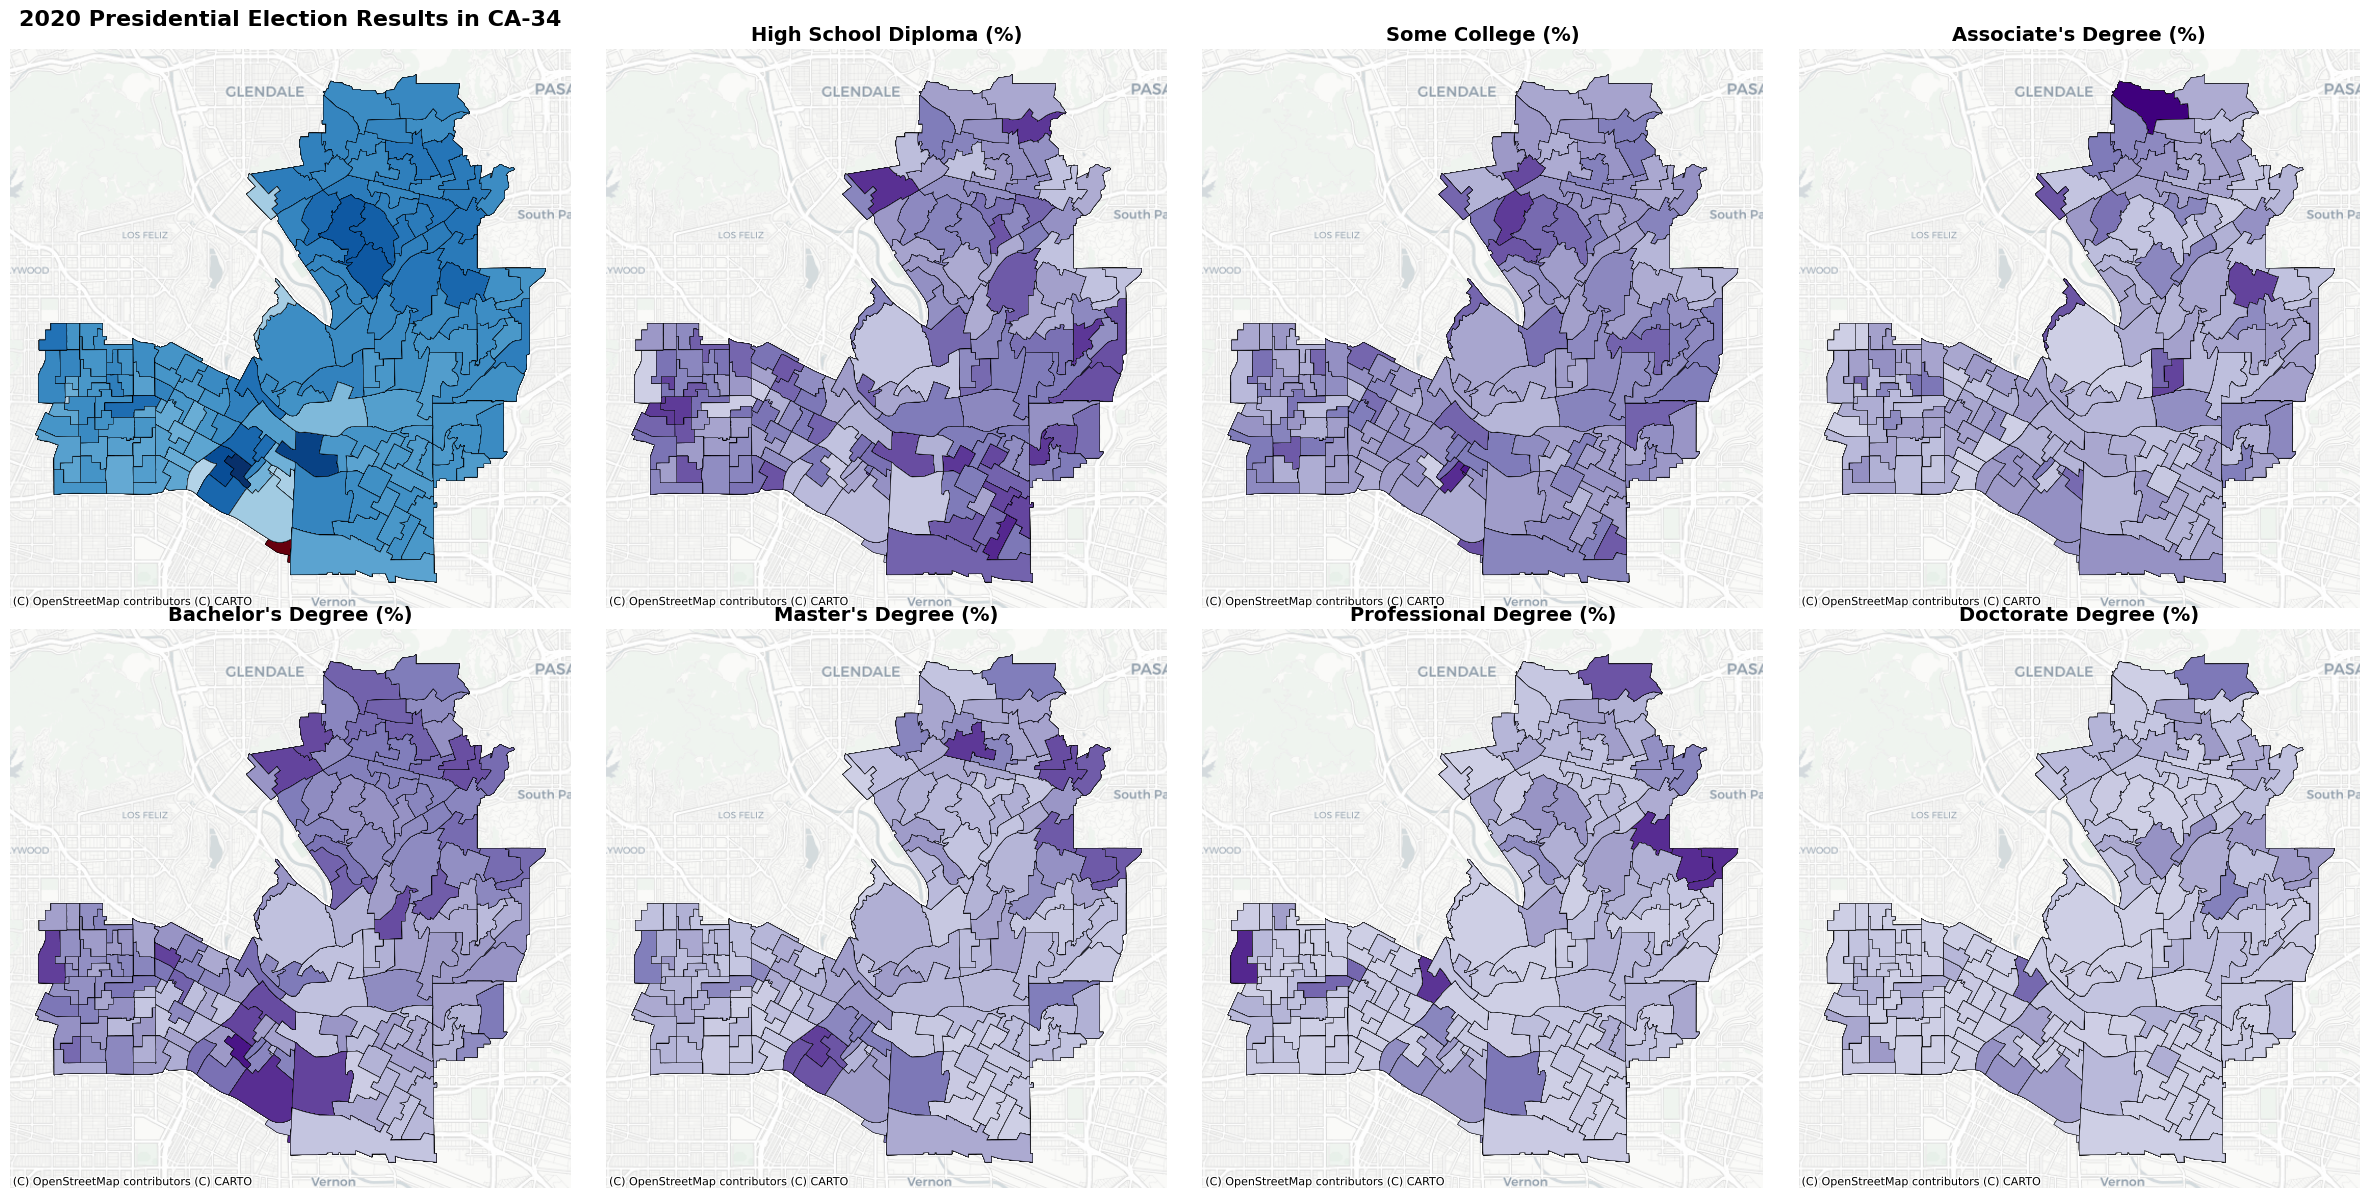

In [5]:
election_data = gpd.read_file("./ca_vest_20/ca_vest_20.shp")
education_data = gpd.read_file("./ca_edu_2022_bg/ca_edu_2022_bg.shp")

if election_data.crs != education_data.crs:
    education_data = education_data.to_crs(election_data.crs)

# Filter for CA-34
ca_34_data = election_data[election_data["CDDIST"] == 34]

if "Margin" not in ca_34_data.columns:
    ca_34_data["Margin"] = ca_34_data["G20PREDBID"] - ca_34_data["G20PRERTRU"]

education_data["Pct_HighSchool"] = (education_data["HS_DIP22"] / education_data["POP_25OV22"]) * 100
education_data["Pct_SomeCollege"] = (education_data["SOM_COLL22"] / education_data["POP_25OV22"]) * 100
education_data["Pct_AssociateDegree"] = (education_data["ASSO_DEG22"] / education_data["POP_25OV22"]) * 100
education_data["Pct_BachelorDegree"] = (education_data["BACH_DEG22"] / education_data["POP_25OV22"]) * 100
education_data["Pct_MasterDegree"] = (education_data["MAST_DEG22"] / education_data["POP_25OV22"]) * 100
education_data["Pct_ProfessionalDegree"] = (education_data["PROF_DEG22"] / education_data["POP_25OV22"]) * 100
education_data["Pct_DoctorateDegree"] = (education_data["DOCT_DEG22"] / education_data["POP_25OV22"]) * 100

# Perform a spatial join to merge election and education data
merged_data = gpd.sjoin(ca_34_data, education_data, how="left", predicate="intersects")

if "Margin" not in merged_data.columns:
    print("Error: 'Margin' column is missing in merged_data.")
else:
    def get_color(row):
        if row["Margin"] > 0:  # Biden won
            return plt.cm.Blues(np.interp(row["Margin"], [0, merged_data["Margin"].max()], [0.3, 1]))
        elif row["Margin"] < 0:  # Trump won
            return plt.cm.Reds(np.interp(abs(row["Margin"]), [0, abs(merged_data["Margin"].min())], [0.3, 1]))
        else:
            return "grey"

    merged_data["Color"] = merged_data.apply(get_color, axis=1)

    education_fields = [
        ("Pct_HighSchool", "High School Diploma (%)"),
        ("Pct_SomeCollege", "Some College (%)"),
        ("Pct_AssociateDegree", "Associate's Degree (%)"),
        ("Pct_BachelorDegree", "Bachelor's Degree (%)"),
        ("Pct_MasterDegree", "Master's Degree (%)"),
        ("Pct_ProfessionalDegree", "Professional Degree (%)"),
        ("Pct_DoctorateDegree", "Doctorate Degree (%)")
    ]

    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    axes = axes.flatten()
    merged_data.plot(color=merged_data["Color"], ax=axes[0], edgecolor="black", linewidth=0.3)
    axes[0].set_title("2020 Presidential Election Results in CA-34", fontsize=16, fontweight="bold")
    axes[0].axis("off")
    ctx.add_basemap(axes[0], crs=merged_data.crs.to_string(), source=ctx.providers.CartoDB.Positron)
    for i, (field, title) in enumerate(education_fields, start=1):
        # Normalize data for color mapping and handle NaN
        merged_data[field] = pd.to_numeric(merged_data[field], errors='coerce').fillna(0)
        merged_data[f"{field}_Color"] = [plt.cm.Purples(np.interp(value,
                                                                 [merged_data[field].min(), merged_data[field].max()],
                                                                 [0.3, 1])) for value in merged_data[field]]

        merged_data.plot(color=merged_data[f"{field}_Color"], ax=axes[i], edgecolor="black", linewidth=0.3)
        axes[i].set_title(title, fontsize=14, fontweight="bold")
        axes[i].axis("off")
        ctx.add_basemap(axes[i], crs=merged_data.crs.to_string(), source=ctx.providers.CartoDB.Positron)

    plt.tight_layout()
    plt.savefig("CA34_Election_Education.png", dpi=300)
    plt.show()

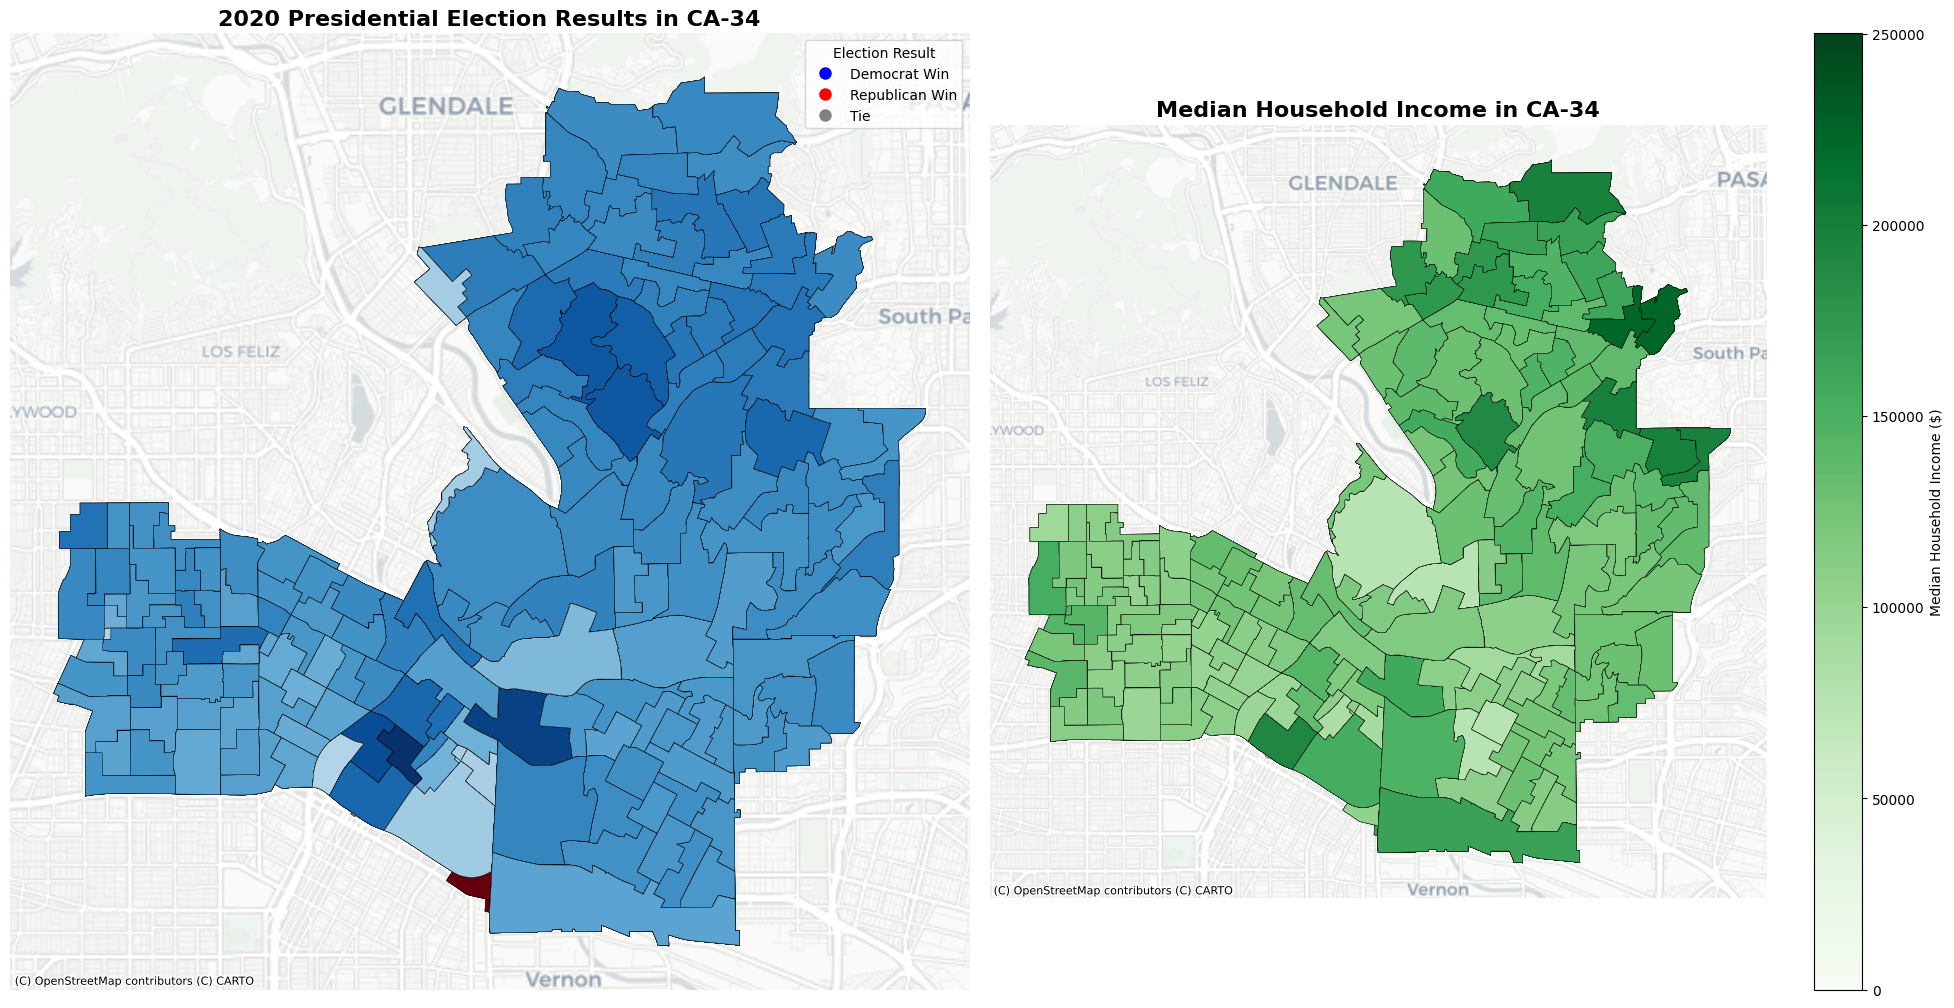

In [6]:
election_data = gpd.read_file("./ca_vest_20/ca_vest_20.shp")
income_data = gpd.read_file("./ca_inc_2022_t/ca_inc_2022_t.shp")

# Filter for CA-34 in election data
ca_34_data = election_data[election_data["CDDIST"] == 34]

# Ensure CRS consistency for spatial join
if ca_34_data.crs != income_data.crs:
    income_data = income_data.to_crs(ca_34_data.crs)

income_data["MEDN_INC22"] = income_data["MEDN_INC22"].replace(-666666666, np.nan)

if 'index_right' in ca_34_data.columns:
    ca_34_data = ca_34_data.rename(columns={'index_right': 'index_right_election'})
if 'index_right' in income_data.columns:
    income_data = income_data.rename(columns={'index_right': 'index_right_income'})

# Perform a spatial join to merge election and income data
merged_data = gpd.sjoin(ca_34_data, income_data, how="left", predicate="intersects")

if "Margin" not in merged_data.columns:
    merged_data["Margin"] = merged_data["G20PREDBID"] - merged_data["G20PRERTRU"]

def get_color(row):
    if row["Margin"] > 0:  # Biden won
        return plt.cm.Blues(np.interp(row["Margin"], [0, merged_data["Margin"].max()], [0.3, 1]))
    elif row["Margin"] < 0:  # Trump won
        return plt.cm.Reds(np.interp(abs(row["Margin"]), [0, abs(merged_data["Margin"].min())], [0.3, 1]))
    else:
        return "grey"

merged_data["Color"] = merged_data.apply(get_color, axis=1)
merged_data["MEDN_INC22"] = pd.to_numeric(merged_data["MEDN_INC22"], errors='coerce').fillna(0)
merged_data["Income_Color"] = [
    plt.cm.Greens(np.interp(value, [merged_data["MEDN_INC22"].min(), merged_data["MEDN_INC22"].max()], [0.3, 1])) 
    for value in merged_data["MEDN_INC22"]
]
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot Election Results (Winner and Margin) with basemap
merged_data.plot(color=merged_data["Color"], ax=axes[0], edgecolor="black", linewidth=0.3)
axes[0].set_title("2020 Presidential Election Results in CA-34", fontsize=16, fontweight="bold")
axes[0].axis("off")
ctx.add_basemap(axes[0], crs=merged_data.crs.to_string(), source=ctx.providers.CartoDB.Positron)

election_legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Democrat Win', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Republican Win', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Tie', markerfacecolor='grey', markersize=10)
]
axes[0].legend(handles=election_legend_elements, loc="upper right", title="Election Result")

# Plot Median Household Income with basemap
merged_data.plot(color=merged_data["Income_Color"], ax=axes[1], edgecolor="black", linewidth=0.3)
axes[1].set_title("Median Household Income in CA-34", fontsize=16, fontweight="bold")
axes[1].axis("off")
ctx.add_basemap(axes[1], crs=merged_data.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add colorbar for Median Household Income
sm = plt.cm.ScalarMappable(cmap="Greens", norm=plt.Normalize(vmin=merged_data["MEDN_INC22"].min(), vmax=merged_data["MEDN_INC22"].max()))
sm._A = []
fig.colorbar(sm, ax=axes[1], orientation="vertical", label="Median Household Income ($)")

plt.tight_layout()
plt.savefig("CA34_Election_median_household.png", dpi=300)
plt.show()


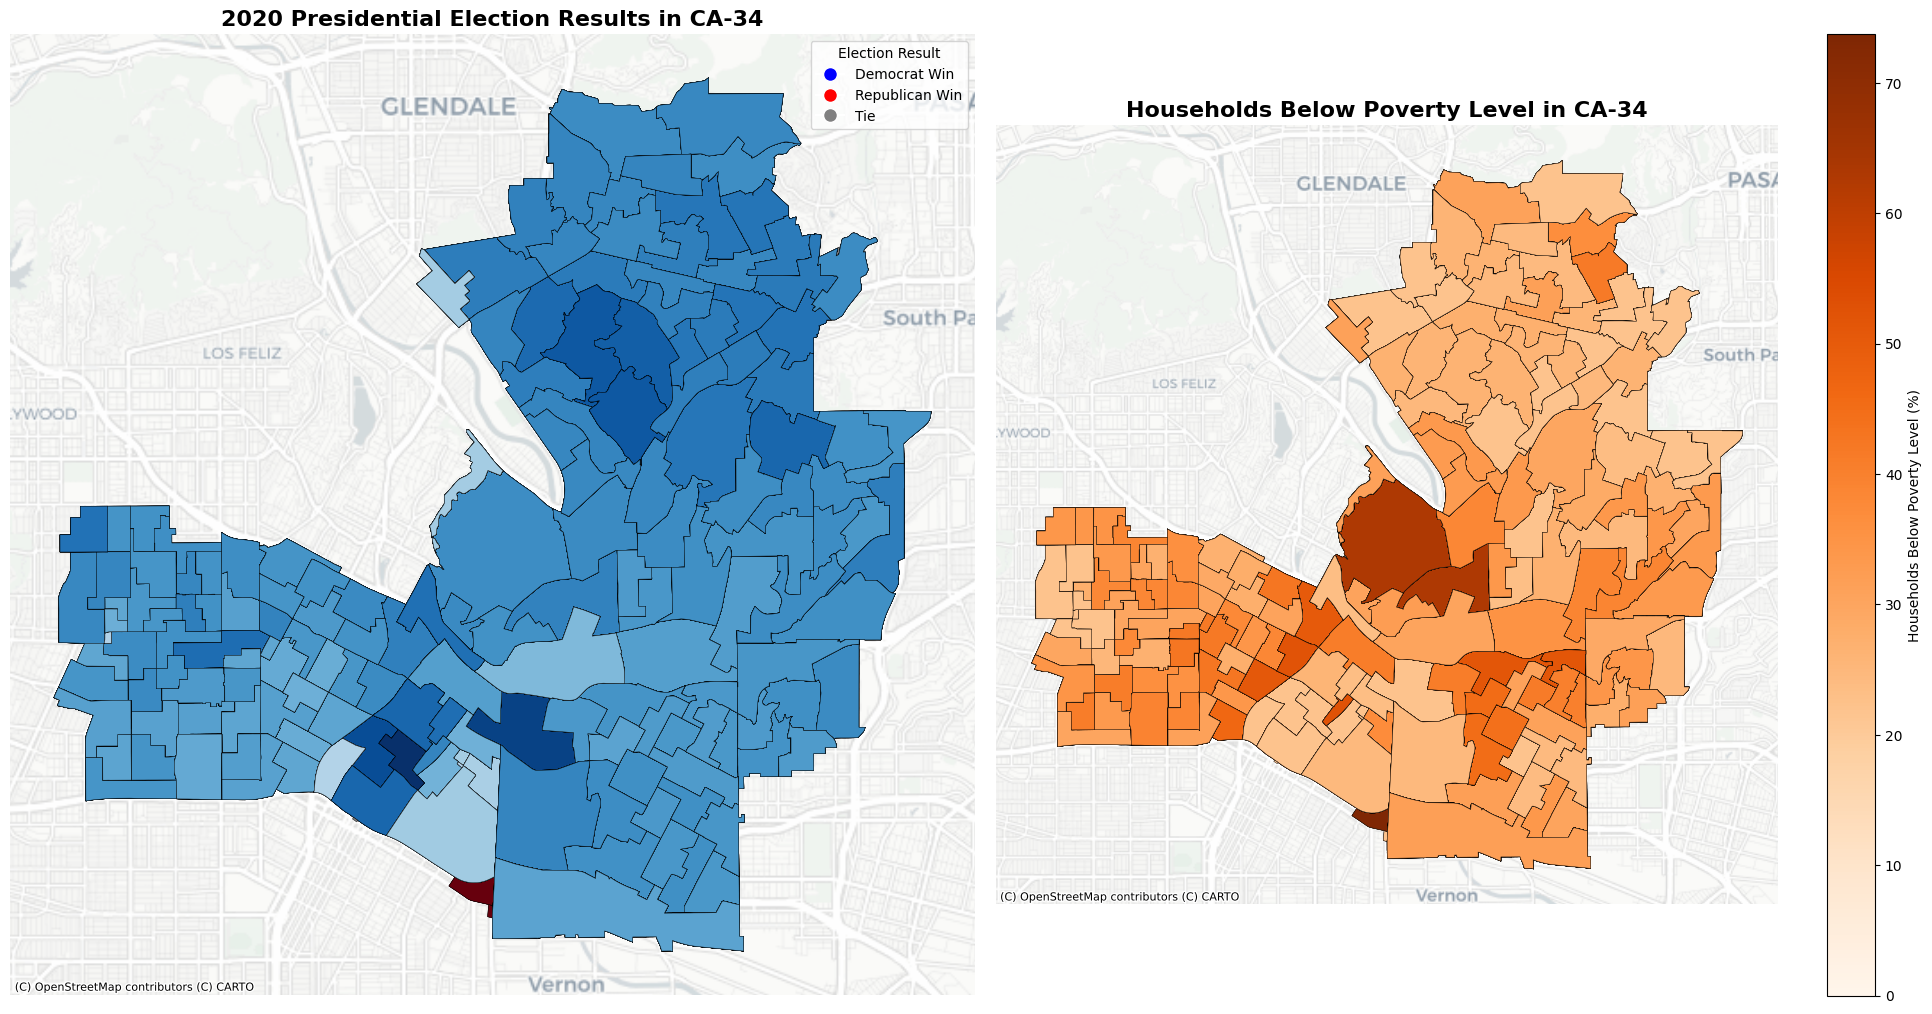

In [9]:
election_data = gpd.read_file("./ca_vest_20/ca_vest_20.shp")
poverty_data = gpd.read_file("./ca_pov_2022_bg/ca_pov_2022_bg.shp")

# Filter for CA-34 in election data
ca_34_data = election_data[election_data["CDDIST"] == 34]

# Ensure CRS consistency for spatial join
if ca_34_data.crs != poverty_data.crs:
    poverty_data = poverty_data.to_crs(ca_34_data.crs)

# Calculate the percentage of households below the poverty line
poverty_data["Pct_Below_Poverty"] = (poverty_data["TOT_BPOV22"] / poverty_data["TOT_HOUS22"]) * 100

# Rename 'index_right' in ca_34_data or poverty_data if it exists
if 'index_right' in ca_34_data.columns:
    ca_34_data = ca_34_data.rename(columns={'index_right': 'index_right_election'})
if 'index_right' in poverty_data.columns:
    poverty_data = poverty_data.rename(columns={'index_right': 'index_right_poverty'})

# Perform a spatial join to merge election and poverty data
merged_data = gpd.sjoin(ca_34_data, poverty_data, how="left", predicate="intersects")

# Ensure that election results data includes columns for Biden and Trump
if "G20PREDBID" in merged_data.columns and "G20PRERTRU" in merged_data.columns:
    # Calculate margin for color coding
    merged_data["Margin"] = merged_data["G20PREDBID"] - merged_data["G20PRERTRU"]
else:
    print("Election data does not include 'G20PREDBID' or 'G20PRERTRU' columns for margin calculation.")

# Define color based on winner margin for Election Results map
def get_color(row):
    if row["Margin"] > 0:  # Biden won
        return plt.cm.Blues(np.interp(row["Margin"], [0, merged_data["Margin"].max()], [0.3, 1]))
    elif row["Margin"] < 0:  # Trump won
        return plt.cm.Reds(np.interp(abs(row["Margin"]), [0, abs(merged_data["Margin"].min())], [0.3, 1]))
    else:
        return "grey"  # For ties or unknown cases

# Apply color mapping for fill color in Election Results map
merged_data["Color"] = merged_data.apply(get_color, axis=1)

# Normalize poverty data for color mapping, handling NaN
merged_data["Pct_Below_Poverty"] = pd.to_numeric(merged_data["Pct_Below_Poverty"], errors='coerce').fillna(0)
merged_data["Poverty_Color"] = [
    plt.cm.Oranges(np.interp(value, 
                             [merged_data["Pct_Below_Poverty"].min(), merged_data["Pct_Below_Poverty"].max()], 
                             [0.3, 1])) 
    for value in merged_data["Pct_Below_Poverty"]
]

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot Election Results (Winner and Margin) with basemap
merged_data.plot(color=merged_data["Color"], ax=axes[0], edgecolor="black", linewidth=0.3)
axes[0].set_title("2020 Presidential Election Results in CA-34", fontsize=16, fontweight="bold")
axes[0].axis("off")
ctx.add_basemap(axes[0], crs=merged_data.crs.to_string(), source=ctx.providers.CartoDB.Positron)

election_legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Democrat Win', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Republican Win', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Tie', markerfacecolor='grey', markersize=10)
]
axes[0].legend(handles=election_legend_elements, loc="upper right", title="Election Result")

# Plot Poverty Level (Households Below Poverty Line) with basemap
merged_data.plot(color=merged_data["Poverty_Color"], ax=axes[1], edgecolor="black", linewidth=0.3)
axes[1].set_title("Households Below Poverty Level in CA-34", fontsize=16, fontweight="bold")
axes[1].axis("off")
ctx.add_basemap(axes[1], crs=merged_data.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add colorbars for Poverty Level map
sm = plt.cm.ScalarMappable(cmap="Oranges", norm=plt.Normalize(vmin=merged_data["Pct_Below_Poverty"].min(), vmax=merged_data["Pct_Below_Poverty"].max()))
sm._A = []
fig.colorbar(sm, ax=axes[1], orientation="vertical", label="Households Below Poverty Level (%)")

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig("CA34_Election_below_poverty.png", dpi=300)
plt.show()


/home/test/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/test/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


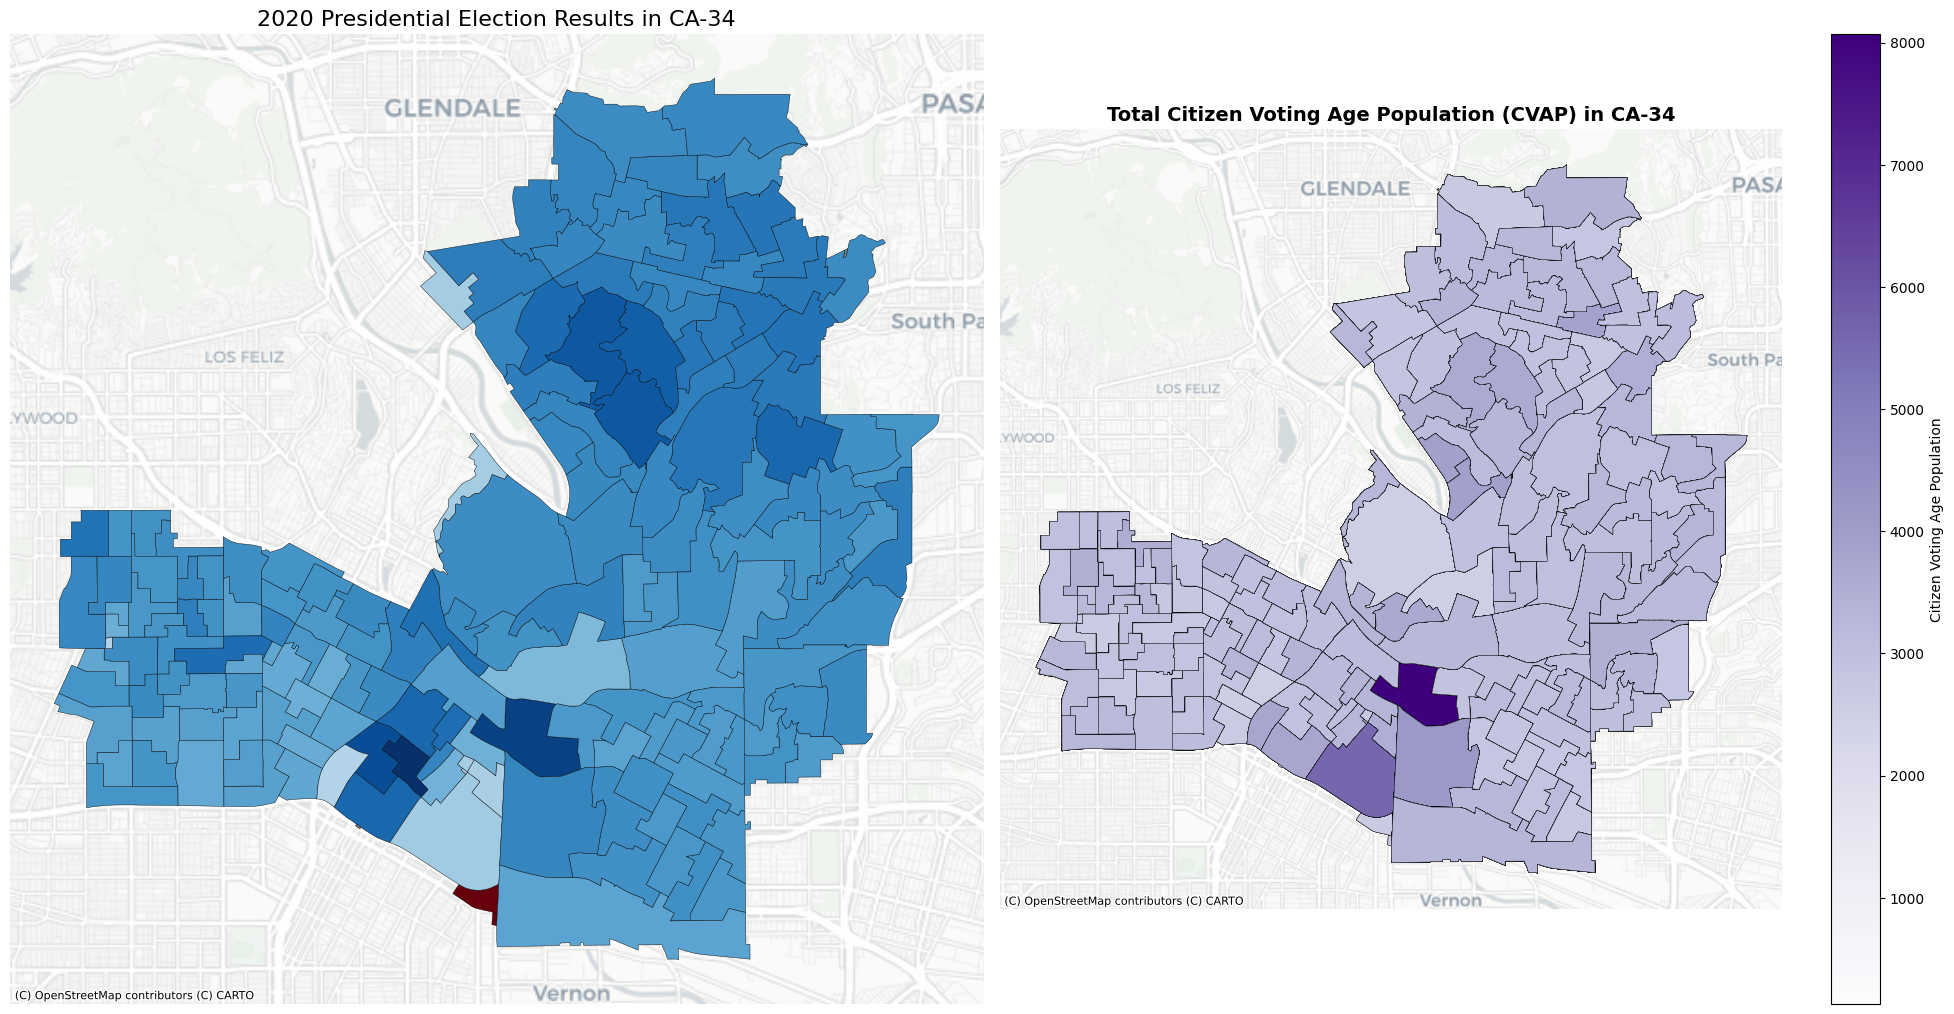

In [8]:
income_data = gpd.read_file("./ca_inc_2022_t/ca_inc_2022_t.shp")
cvap_data = gpd.read_file("./ca_cvap_2022_bg/ca_cvap_2022_bg.shp")

if ca_34_data.crs != income_data.crs:
    income_data = income_data.to_crs(ca_34_data.crs)
if ca_34_data.crs != cvap_data.crs:
    cvap_data = cvap_data.to_crs(ca_34_data.crs)

income_data["MEDN_INC22"] = income_data["MEDN_INC22"].replace(-666666666, np.nan)
cvap_data["CVAP_TOT22"] = cvap_data["CVAP_TOT22"].replace(-999999, np.nan)

# Calculate election margin (Biden - Trump) in CA-34
ca_34_data["Margin"] = ca_34_data["G20PREDBID"] - ca_34_data["G20PRERTRU"]

# Spatial join: Election with Income data for CA-34
merged_income_data = gpd.sjoin(ca_34_data, income_data, how="left", predicate="intersects")

# Spatial join: Election with CVAP data for CA-34
merged_cvap_data = gpd.sjoin(ca_34_data, cvap_data, how="left", predicate="intersects")

def get_color(row, max_margin, min_margin):
    if row["Margin"] > 0:  # Biden won
        return plt.cm.Blues(np.interp(row["Margin"], [0, max_margin], [0.3, 1]))
    elif row["Margin"] < 0:  # Trump won
        return plt.cm.Reds(np.interp(abs(row["Margin"]), [0, abs(min_margin)], [0.3, 1]))
    else:
        return "grey"

max_margin = ca_34_data["Margin"].max()
min_margin = ca_34_data["Margin"].min()
ca_34_data["Color"] = ca_34_data.apply(get_color, axis=1, max_margin=max_margin, min_margin=min_margin)

merged_income_data["MEDN_INC22"] = pd.to_numeric(merged_income_data["MEDN_INC22"], errors='coerce').fillna(0)
merged_income_data["Income_Color"] = [plt.cm.Greens(np.interp(value,
                                                             [merged_income_data["MEDN_INC22"].min(), merged_income_data["MEDN_INC22"].max()],
                                                             [0.3, 1])) for value in merged_income_data["MEDN_INC22"]]

merged_cvap_data["CVAP_TOT22"] = pd.to_numeric(merged_cvap_data["CVAP_TOT22"], errors='coerce').fillna(0)
merged_cvap_data["CVAP_Color"] = [plt.cm.Purples(np.interp(value,
                                                          [merged_cvap_data["CVAP_TOT22"].min(), merged_cvap_data["CVAP_TOT22"].max()],
                                                          [0.3, 1])) for value in merged_cvap_data["CVAP_TOT22"]]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
ca_34_data.plot(color=ca_34_data["Color"], ax=axes[0], edgecolor="black", linewidth=0.3)
axes[0].set_title("2020 Presidential Election Results in CA-34", fontsize=16)
axes[0].axis("off")
ctx.add_basemap(axes[0], crs=ca_34_data.crs.to_string(), source=ctx.providers.CartoDB.Positron)
merged_cvap_data.plot(color=merged_cvap_data["CVAP_Color"], ax=axes[1], edgecolor="black", linewidth=0.3)
axes[1].set_title("Total Citizen Voting Age Population (CVAP) in CA-34", fontsize=14, fontweight="bold")
axes[1].axis("off")
ctx.add_basemap(axes[1], crs=merged_cvap_data.crs.to_string(), source=ctx.providers.CartoDB.Positron)
sm_cvap = plt.cm.ScalarMappable(cmap="Purples", norm=plt.Normalize(vmin=merged_cvap_data["CVAP_TOT22"].min(), vmax=merged_cvap_data["CVAP_TOT22"].max()))
sm_cvap._A = []
fig.colorbar(sm_cvap, ax=axes[1], orientation="vertical", label="Citizen Voting Age Population")

plt.tight_layout()
plt.savefig("CA34_Election_voting_age.png", dpi=300)
plt.show()